In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import plotly_express as px

In [4]:
metadata_df = pd.read_csv("train_metadata.csv", index_col="sample")
data_df = pd.read_csv("train_data.csv",  index_col="sample")

In [5]:
metadata_df.columns

Index(['baboon_id', 'collection_date', 'sex', 'age', 'social_group',
       'group_size', 'rain_month_mm', 'season', 'hydro_year', 'month',
       'diet_PC1', 'diet_PC2', 'diet_PC3', 'diet_PC4', 'diet_PC5', 'diet_PC6',
       'diet_PC7', 'diet_PC8', 'diet_PC9', 'diet_PC10', 'diet_PC11',
       'diet_PC12', 'diet_PC13'],
      dtype='object')

full correlation between moth and season - no need to take both
6-10 - wet else dry.



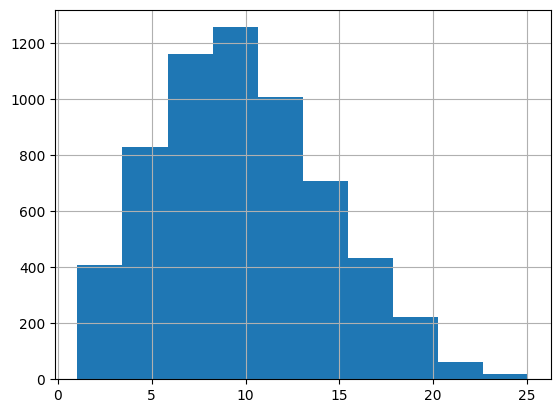

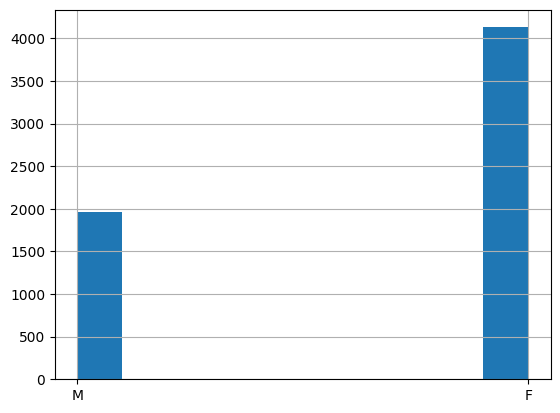

In [6]:
metadata_df["age"].hist()

plt.show()
metadata_df["sex"].hist()

plt.show()


In [7]:
metadata_df_M = metadata_df[metadata_df["sex"]=="M"]
metadata_df_F = metadata_df[metadata_df["sex"]=="F"]

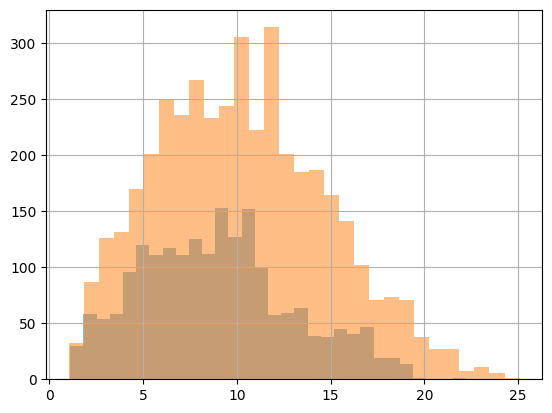

In [8]:
metadata_df_M["age"].hist(bins = 30, alpha=0.5)

metadata_df_F["age"].hist(bins=30, alpha=0.5)

plt.show()

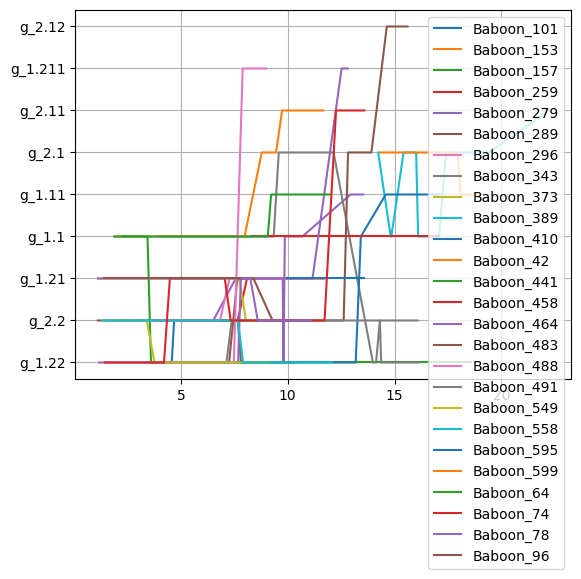

In [9]:
for baboon in metadata_df_M["baboon_id"].unique():
    age = metadata_df_M["age"][metadata_df_M["baboon_id"] == baboon]
    social_group = metadata_df_M["social_group"][metadata_df_M["baboon_id"] == baboon]
    plt.plot(age, social_group, label=baboon)
    
plt.grid()
plt.legend()
plt.show()

In [10]:
# make sure the data is sorted by sample date
metadata_df_M.sort_values(by=["baboon_id","collection_date"], inplace=True)


C:\Users\tomer\AppData\Local\Temp\ipykernel_62500\3969196945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df_M.sort_values(by=["baboon_id","collection_date"], inplace=True)


In [11]:
# for each baboon - summig  up the number of social group change over the years.
number_of_group_change_M = []
for baboon in metadata_df_M["baboon_id"].unique():
    baboon_df = pd.DataFrame({"social_group":metadata_df_M["social_group"][metadata_df_M["baboon_id"]==baboon]})
    baboon_df["next_social_group"] = baboon_df["social_group"].shift(1)
    group_change = (baboon_df["next_social_group"] != baboon_df["social_group"]).astype('int')
    number_of_group_change_M.append(np.sum(group_change)-1)
    
number_of_group_change_F = []
for baboon in metadata_df_F["baboon_id"].unique():
    baboon_df = pd.DataFrame({"social_group":metadata_df_F["social_group"][metadata_df_F["baboon_id"]==baboon]})
    baboon_df["next_social_group"] = baboon_df["social_group"].shift(1)
    group_change = (baboon_df["next_social_group"] != baboon_df["social_group"]).astype('int')
    number_of_group_change_F.append(np.sum(group_change)-1)



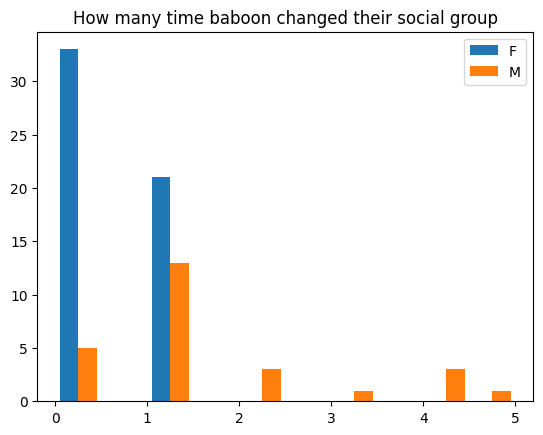

In [12]:
plt.hist([number_of_group_change_F,number_of_group_change_M], label=["F","M"])
plt.legend()
plt.title("How many time baboon changed their social group")
plt.show()

In [13]:
np.mean(metadata_df.groupby("baboon_id")["collection_date"].count())

76.2

1. clustering baboons by averege microbiome profile.
2. changes in samples throughout time for each baboon.

In [26]:
# add baboon_id column
data_df["baboon_id"] = metadata_df["baboon_id"]

data_df_avg = data_df.groupby("baboon_id").mean()

100%|██████████| 8/8 [00:00<00:00,  9.69it/s]


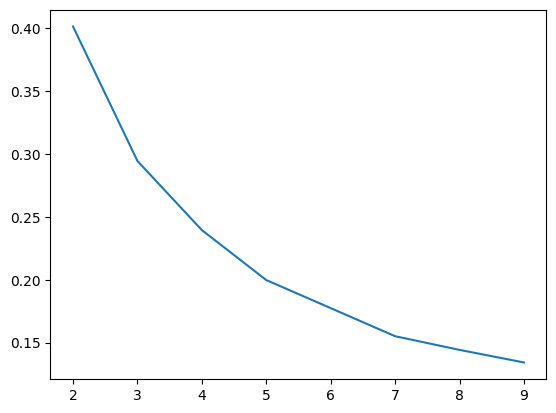

In [27]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans


distortions = []
for k in tqdm(range(2, 10)):
    val = 0
    for _ in range(10):
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data_df_avg.values)
        val += kmeans.inertia_
    
    distortions.append(val/10)
plt.plot(range(2,10),distortions)



In [28]:
kmean = KMeans(n_clusters=5, n_init=10)
labels = kmean.fit(data_df_avg.values).labels_

100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Text(0, 0.5, 'Inertia')

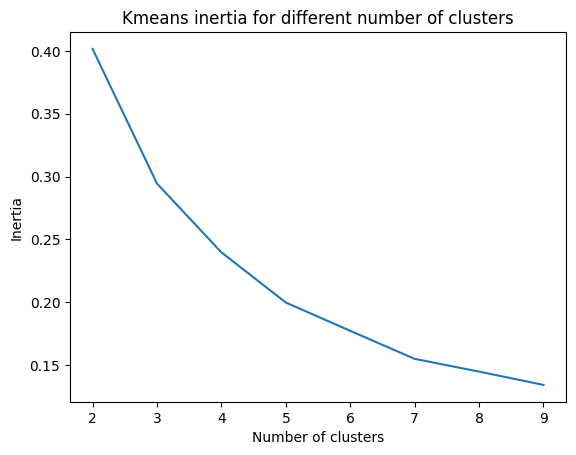

In [41]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans


distortions = []
for k in tqdm(range(2, 10)):
    val = 0
    for _ in range(10):
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data_df_avg.values)
        val += kmeans.inertia_
    
    distortions.append(val/10)
plt.plot(range(2,10),distortions)
plt.title("Kmeans inertia for different number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")


In [30]:
kmean = KMeans(n_clusters=5, n_init=10)
labels = kmean.fit(data_df_avg.values).labels_

In [31]:

feature_df = metadata_df[["sex","baboon_id","social_group"]]
px.parallel_categories(feature_df)


In [32]:
feature_df["baboon_id"].values in ["Baboon_101"]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
results = pd.DataFrame(pca.fit_transform(data_df_avg), columns=["PC1", "PC2", "PC3"])

In [34]:
px.scatter_3d(results.iloc[:,:3], x="PC1", y="PC2", z="PC3", color=labels)

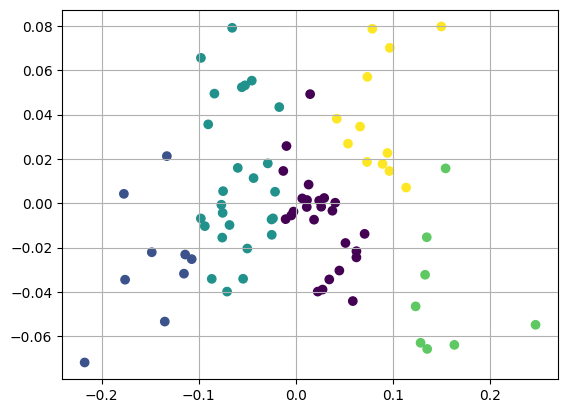

In [35]:
pca = PCA(n_components=2)
results = pca.fit_transform(data_df_avg).transpose()

plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()

In [36]:
import umap

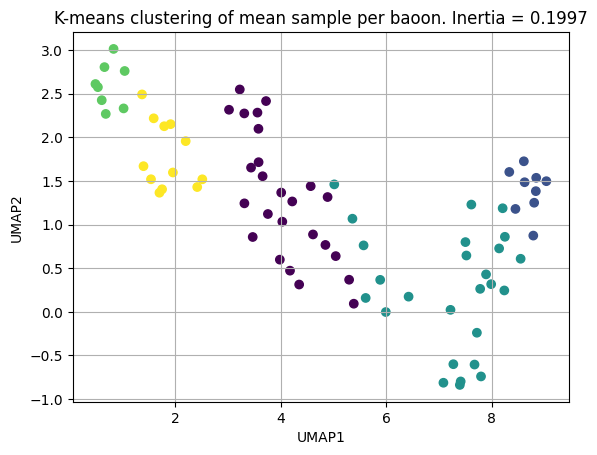

In [43]:
reducer = umap.UMAP()
results = reducer.fit_transform(data_df_avg.values).transpose()

plt.scatter(results[0], results[1], c=labels)
plt.grid()

plt.title(f"K-means clustering of mean sample per baoon. Inertia = {np.around(distortions[5-2],4)}")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

In [ ]:
metadata_df_F["season"]

In [ ]:
metadata_df_D_F = metadata_df_F[metadata_df_F["season"]=="dry"]
metadata_df_W_F = metadata_df_F[metadata_df_F["season"]=="wet"]
metadata_df_D_M = metadata_df_M[metadata_df_M["season"]=="dry"]
metadata_df_W_M = metadata_df_M[metadata_df_M["season"]=="wet"]

In [ ]:
data_df["season"] = metadata_df["season"]
data_df_avg_season = data_df.groupby(["baboon_id","season"]).mean()


In [ ]:
data_df_avg_season

In [ ]:
metadata_df_M["baboon_id"].unique()

In [ ]:
data_df_avg_M_D = data_df_avg_season.loc[(metadata_df_M["baboon_id"].unique(),'dry'),:]
data_df_avg_M_W = data_df_avg_season.loc[(metadata_df_M["baboon_id"].unique(),'wet'),:]
data_df_avg_F_D = data_df_avg_season.loc[(metadata_df_F["baboon_id"].unique(),'dry'),:]
data_df_avg_F_W = data_df_avg_season.loc[(metadata_df_F["baboon_id"].unique(),'wet'),:]

In [ ]:
data_df_avg_M_D["sex"] = 0
data_df_avg_F_D["sex"] = 1
data_df_avg_M_W["sex"] = 0
data_df_avg_F_W["sex"] = 1

data_df_avg_D = pd.concat([data_df_avg_M_D, data_df_avg_F_D])
data_df_avg_W = pd.concat([data_df_avg_M_W, data_df_avg_F_W])



data_df_avg_D

In [ ]:
labels = data_df_avg_D["sex"].values
pca = PCA(n_components=3)
results = pca.fit_transform(data_df_avg_D.drop(columns="sex"))


px.scatter_3d(pd.DataFrame(results, columns=["PC1", "PC2", "PC3"]), x="PC1", y="PC2", z="PC3", color=labels)



In [ ]:
reducer = umap.UMAP()
results = reducer.fit_transform(data_df_avg_D.drop(columns="sex").values).transpose()

plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()

In [ ]:
labels = data_df_avg_W["sex"].values
pca = PCA(n_components=3)
results = pca.fit_transform(data_df_avg_W.drop(columns="sex"))


px.scatter_3d(pd.DataFrame(results, columns=["PC1", "PC2", "PC3"]), x="PC1", y="PC2", z="PC3", color=labels)

In [ ]:
reducer = umap.UMAP()
results = reducer.fit_transform(data_df_avg_W.drop(columns="sex").values).transpose()
plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()

In [ ]:
[data_df_avg_season.reset_index()["season"]=='dry']

In [ ]:
labels = (data_df_avg_season.reset_index()["season"]=='dry').astype(int).values
pca = PCA(n_components=3)
results = pca.fit_transform(data_df_avg_season)
px.scatter_3d(pd.DataFrame(results, columns=["PC1", "PC2", "PC3"]), x="PC1", y="PC2", z="PC3", color=labels)



In [ ]:

reducer = umap.UMAP()
results = reducer.fit_transform(data_df_avg_season.values).transpose()

plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()

In [ ]:
Df = data_df_avg_D.copy().reset_index(level=1, drop=True)
Wf = data_df_avg_W.copy().reset_index(level=1, drop=True)

In [ ]:
diff = []

for baboon in metadata_df["baboon_id"].unique():
    diff.append(Df.loc[baboon]- Wf.loc[baboon].values)
diff = np.array(diff).T
# avg = [diff[i].mean() for i in range(len(diff))]
# avg.sort()
# print(avg)

# for row in np.array(diff).T:
row = diff[22]
row.sort()
sns.kdeplot(row)
plt.vlines(np.percentile(row, 2.5), ymin=0,ymax=100, color ="black", label="CI")
plt.vlines(np.percentile(row, 97.5), ymin=0,ymax=100, color ="black")
plt.legend()
plt.xlim(-0.05, 0.05)
plt.show()


### changes in samples throughout time for each baboon.

In [ ]:
data_df["collection_date"] = metadata_df["collection_date"]
data_df.sort_values(by=["baboon_id","collection_date"],inplace=True)

In [ ]:
df = metadata_df[data_df["baboon_id"]=="Baboon_107"]

In [ ]:
df.sort_values("collection_date", inplace=True)
df["collection_date"]= pd.to_datetime(metadata_df['collection_date'])
days_diff = df["collection_date"].diff().values/np.timedelta64(1,"D")
len(days_diff[days_diff>180])

In [ ]:
number_of_long_diffs = []
l = []
for baboon in metadata_df.baboon_id.unique():
    df = metadata_df.loc[data_df["baboon_id"]==baboon]
    df = df.sort_values("collection_date")
    df["collection_date"]= pd.to_datetime(metadata_df['collection_date'])
    days_diff = df["collection_date"].diff().values/np.timedelta64(1,"D")
    np.asarray(days_diff>360).nonzero()
    l.append(np.diff(np.concatenate([[0],np.asarray(days_diff>200).nonzero()[0], [len(days_diff)]])))
    number_of_long_diffs.append(len(days_diff[days_diff>182]))

number_of_long_diffs = np.array(number_of_long_diffs)

In [ ]:
sns.barplot(x=range(max(number_of_long_diffs)+1), y=[len(number_of_long_diffs [number_of_long_diffs == i]) for i in range(max(number_of_long_diffs)+1)])
plt.ylabel("Number of baboons")
plt.xlabel("Number of long gaps")
plt.title("Number of long gaps between samples")
plt.show()

In [ ]:
np.concatenate([[0],np.asarray(days_diff>182).nonzero()[0], [len(days_diff)]])

In [ ]:
np.asarray(days_diff>180).nonzero()

In [ ]:
np.diff(np.concatenate([[0],np.asarray(days_diff>180).nonzero()[0], [len(days_diff)]]))

In [ ]:
np.diff

In [ ]:
df.iloc[1:73]

In [ ]:
np.asarray(number_of_long_diffs==4).nonzero()

In [ ]:
sns.histplot(number_of_long_diffs, bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5])

In [ ]:
df=df.drop(columns=["baboon_id"])
df.set_index("collection_date")